<a href="https://colab.research.google.com/github/7amzaGH/5G-Network-Slicing-Optimization/blob/main/code/solver_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **5G Network Slicing Optimization using ILP**
# **Author: Hamza Ghitri**



In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 33.1 MB/s eta 0:00:00


# **Main code**

In [4]:

from pulp import LpMaximize, LpProblem, LpVariable, lpSum, value

# -------------------------------
# Define data
# -------------------------------
slices = ["slice1", "slice2", "slice3"]
links = ["link1", "link2"]
time_slots = [1, 2]

# Link capacity (Mbps)
capacity = {"link1": 100, "link2": 120}

# Slice demand per link per time slot
demand = {
    ("slice1", "link1", 1): 50,
    ("slice1", "link2", 1): 40,
    ("slice1", "link1", 2): 30,  # Added time slot 2
    ("slice1", "link2", 2): 35,

    ("slice2", "link1", 1): 30,
    ("slice2", "link2", 1): 60,
    ("slice2", "link1", 2): 40,  # Added time slot 2
    ("slice2", "link2", 2): 50,

    ("slice3", "link1", 1): 40,
    ("slice3", "link2", 1): 50,
    ("slice3", "link1", 2): 45,  # Added time slot 2
    ("slice3", "link2", 2): 40,
}

# -------------------------------
# Define model
# -------------------------------
model = LpProblem("5G_Network_Slicing_Optimization", LpMaximize)

# Decision variable: x[slice, link, t] = 1 if bandwidth allocated, 0 otherwise
x = LpVariable.dicts("x", (slices, links, time_slots), cat="Binary")

# Objective: maximize total allocated bandwidth across all time slots
model += lpSum(
    demand.get((s, l, t), 0) * x[s][l][t]
    for s in slices
    for l in links
    for t in time_slots
), "TotalBandwidth"

# Constraints: total usage per link per time slot <= capacity
for l in links:
    for t in time_slots:
        model += (
            lpSum(demand.get((s, l, t), 0) * x[s][l][t] for s in slices) <= capacity[l],
            f"Capacity_{l}_T{t}"
        )

# Fairness constraint: each slice must get at least one allocation per time slot
for s in slices:
    for t in time_slots:
        model += (
            lpSum(x[s][l][t] for l in links) >= 1,
            f"Fairness_{s}_T{t}"
        )

# -------------------------------
# Solve
# -------------------------------
print("=" * 50)
print("5G NETWORK SLICING OPTIMIZATION")
print("=" * 50)
print("\nSolving the model...\n")

status = model.solve()

# -------------------------------
# Results
# -------------------------------
print("Status:", "Optimal" if status == 1 else "Not Optimal")
print(f"Solver: {model.solver}")
print("\n" + "=" * 50)
print("ALLOCATION RESULTS")
print("=" * 50)

total_bandwidth = 0
for t in time_slots:
    print(f"\n Time Slot {t}:")
    print("-" * 40)
    for s in slices:
        allocated = []
        for l in links:
            if value(x[s][l][t]) == 1:
                bw = demand.get((s, l, t), 0)
                allocated.append(f"{l}: {bw} Mbps")
                total_bandwidth += bw
        if allocated:
            print(f"  {s:10} → {', '.join(allocated)}")

print("\n" + "=" * 50)
print(f" Total Optimized Bandwidth: {total_bandwidth} Mbps")
print(f" Objective Value: {value(model.objective)}")
print("=" * 50)

5G NETWORK SLICING OPTIMIZATION

Solving the model...

Status: Optimal
Solver: <pulp.apis.coin_api.PULP_CBC_CMD object at 0x7e3a99893d70>

ALLOCATION RESULTS

 Time Slot 1:
----------------------------------------
  slice1     → link1: 50 Mbps
  slice2     → link2: 60 Mbps
  slice3     → link1: 40 Mbps, link2: 50 Mbps

 Time Slot 2:
----------------------------------------
  slice1     → link2: 35 Mbps
  slice2     → link1: 40 Mbps, link2: 50 Mbps
  slice3     → link1: 45 Mbps

 Total Optimized Bandwidth: 370 Mbps
 Objective Value: 370.0


# Simple bar chart of all allocations

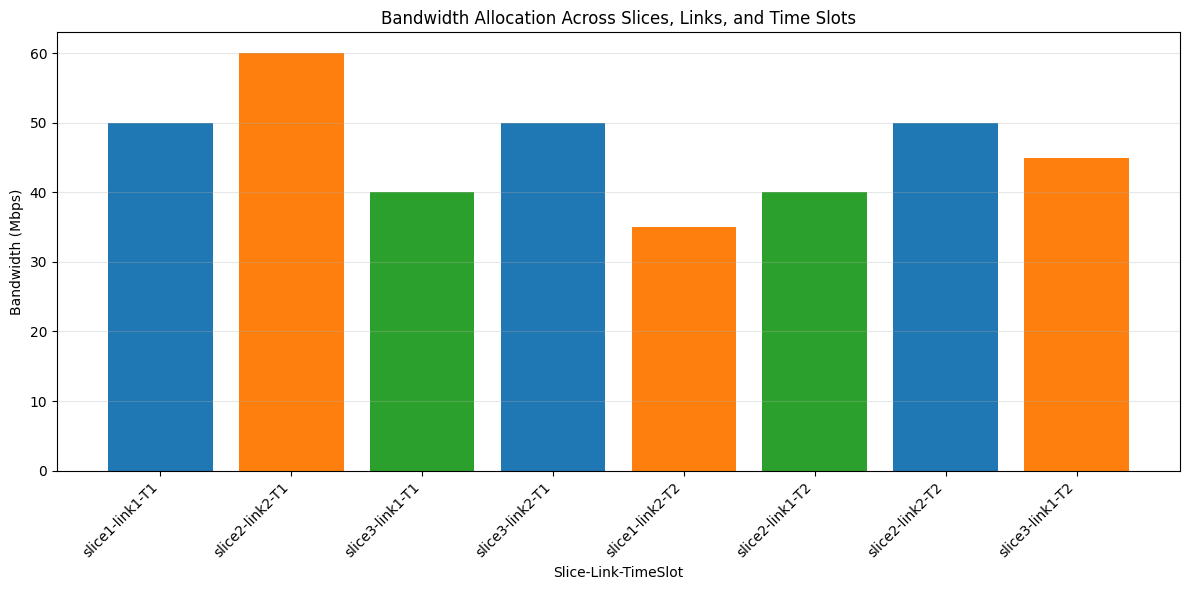

In [3]:
import matplotlib.pyplot as plt
# Simple bar chart of all allocations
allocations = []
labels = []

for t in time_slots:
    for s in slices:
        for l in links:
            if value(x[s][l][t]) == 1:
                allocations.append(demand.get((s, l, t), 0))
                labels.append(f"{s}-{l}-T{t}")

plt.figure(figsize=(12, 6))
plt.bar(labels, allocations, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xlabel('Slice-Link-TimeSlot')
plt.ylabel('Bandwidth (Mbps)')
plt.title('Bandwidth Allocation Across Slices, Links, and Time Slots')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()